In [1]:
import numpy as np
import pandas as pd

import re
import ipywidgets as widgets

from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'YuGothic'
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from IPython.core.pylabtools import figsize
pd.set_option('display.max_columns', 100)

## データの読み込み

In [2]:
# データの読み込み
tokyo=pd.read_csv('13_Tokyo.csv', encoding='cp932')#東京都の土地価格
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## 探索的データ解析

In [3]:
train.head()

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
0,1,75000,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間
1,2,76000,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間
2,3,110000,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,南,22.05m2,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間
3,4,150000,東京都杉並区高円寺南２丁目23-2,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,2LDK,29年4ヶ月,南,60.48m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。
4,5,74000,東京都葛飾区金町３丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,31年7ヶ月,南,39.66m2,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,NaN,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間


In [4]:
train.dtypes

id         int64
賃料         int64
所在地       object
アクセス      object
間取り       object
築年数       object
方角        object
面積        object
所在階       object
バス・トイレ    object
キッチン      object
放送・通信     object
室内設備      object
駐車場       object
周辺環境      object
建物構造      object
契約期間      object
dtype: object

In [5]:
tokyo.head()

,No,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,取引価格（総額）,坪単価,間取り,面積,取引価格（㎡単価）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等
0,1,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,九段下,4,98000000,NaN,２ＬＤＫ,65,NaN,NaN,NaN,NaN,平成15年,ＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,80.0,500.0,2019年第１四半期,改装済,NaN
1,2,中古マンション等,NaN,13101,東京都,千代田区,一番町,麹町,3,58000000,NaN,１ＬＤＫ,40,NaN,NaN,NaN,NaN,平成24年,ＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,80.0,500.0,2019年第１四半期,未改装,NaN
2,3,宅地(土地),住宅地,13101,東京都,千代田区,一番町,半蔵門,4,1000000000,9300000.0,NaN,360,2800000.0,台形,12,NaN,NaN,NaN,NaN,その他,北西,区道,17.0,第２種住居地域,60.0,400.0,2019年第１四半期,NaN,NaN
3,4,中古マンション等,NaN,13101,東京都,千代田区,一番町,半蔵門,3,120000000,NaN,２ＬＤＫ,70,NaN,NaN,NaN,NaN,平成16年,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,80.0,500.0,2019年第１四半期,未改装,NaN
4,5,中古マンション等,NaN,13101,東京都,千代田区,一番町,半蔵門,1,35000000,NaN,１Ｋ,25,NaN,NaN,NaN,NaN,平成25年,ＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,80.0,500.0,2019年第１四半期,未改装,NaN


C:\Users\tkst\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\tkst\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


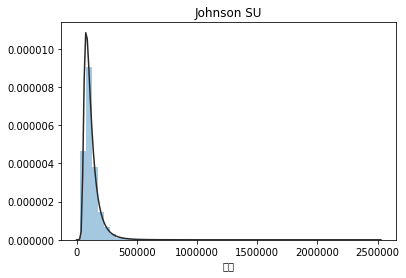

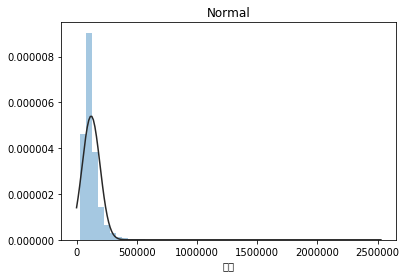

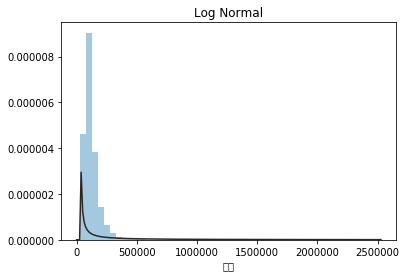

In [6]:
# 目的変数のヒストグラムと分布をプロット
y = train['賃料']
## ジョンソンSU分布
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)

## 正規分布
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)

## 対数正規分布
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

In [7]:
# 特徴量のみのデータを作成
train_features = train#.drop(['賃料'], axis=1)
test_features = test
#features = pd.concat([train_features, test_features]).reset_index(drop=True)
features = train
print(features.shape)

(31470, 17)


In [8]:
features.columns

Index(['id', '賃料', '所在地', 'アクセス', '間取り', '築年数', '方角', '面積', '所在階', 'バス・トイレ',
       'キッチン', '放送・通信', '室内設備', '駐車場', '周辺環境', '建物構造', '契約期間'],
      dtype='object')

In [9]:
features_init = ['所在地', 'アクセス', '間取り', '築年数', '方角', '面積', '所在階', 'バス・トイレ', 'キッチン',
       '放送・通信', '室内設備', '駐車場', '周辺環境', '建物構造', '契約期間']

In [10]:
# 欠損値の数を確認
features.isnull().sum()

id           0
賃料           0
所在地          0
アクセス         0
間取り          0
築年数          0
方角        2749
面積           0
所在階          0
バス・トイレ     329
キッチン       621
放送・通信     3440
室内設備        82
駐車場       5287
周辺環境      9432
建物構造         0
契約期間      7120
dtype: int64

In [11]:
# 各特徴量のユニークな値の個数を見る
@widgets.interact(column=features.columns)
def fetures_value_counts(column):
  return features[column].value_counts(dropna=False)

interactive(children=(Dropdown(description='column', options=('id', '賃料', '所在地', 'アクセス', '間取り', '築年数', '方角', '…

In [12]:
train[train['放送・通信'] == 'BSアンテナ']['賃料'].mean()

107991.58730158731

In [13]:
train['賃料'].mean()

118290.30641881157

## 前処理

In [14]:
#異常データの処理
features['アクセス'] = features['アクセス'].str.replace('三田(兵庫県)駅','三田(東京都)駅')
features.replace({'所在階' : '地下(\d)階／'},r'\1階／',regex=True, inplace=True)
features.loc[features['間取り'] =='11R', '間取り'] = '1R'

In [15]:
# データ内に特定の文字があるかどうかを検索して、ダミー変数を作成する関数
def extract_dummy(string, word):
    id = string.find(word)
    if id == -1:
        return 0
    else:
        return 1

def extract_dummy2(string, word, word2):
    id = string.find(word)
    
    if id2 != -1:
        return 0
    elif id != -1:
        return 1

def extract_dummy3(string, word_list):
    for word in word_list:
        id = string.find(word)
        if id != -1:
            return 1
    return 0

#特定の特徴量を正規化する関数
def feature_norm (feature,features):
    return (feature-features.min())/(features.max()-features.min())

In [16]:
# アクセスの処理
## 路線一覧の作成
JR = ['総武線・中央線（各停）', '常磐線快速', '埼京線', '中央線（快速線）', '京浜東北線', '常磐線', '山手線', '京葉線(東京－蘇我)',
      '東北本線（宇都宮線）', '東海道本線', '湘南新宿ライン(東北本線－横須賀線)', '湘南新宿ライン(高崎線－東海道本線)', '東北新幹線',
      '中央本線(東京－松本)', '総武本線', '東海道新幹線', '高崎線', '横須賀線', '南武線(川崎－立川)']
seibu = ['西武池袋線', '西武新宿線', '西武豊島線', '西武有楽町線']
tokyo_underground = ['有楽町線', '南北線', '銀座線', '半蔵門線', '副都心線', '東西線', '日比谷線', '千代田線', '丸ノ内線(中野坂上－方南町)',
                     '丸ノ内線(池袋－荻窪)']
keio = ['京王線', '京王新線', '京王井の頭線']
tokyu = ['東急東横線', '東急大井町線', '東急池上線', '東急目黒線', '東急多摩川線', '東急世田谷線']
tokyo_kotu = ['都営三田線', '都営大江戸線', '都営浅草線', '都営新宿線', '東急田園都市線', '日暮里・舎人ライナー', '都電荒川線']
tobu = ['東武東上線', '東武スカイツリーライン', '東武亀戸線', '東武大師線', '東武伊勢崎線(押上－曳舟)']
keisei = ['京成金町線', '京成本線', '京成押上線', '京成成田空港線']
keikyu = ['京急本線', '京急空港線']
odakyu = ['小田急小田原線']
tx = ['つくばエクスプレス']
yurikamome = ['ゆりかもめ']
saitama = ['埼玉高速鉄道線']
tokyo_monorail = ['東京モノレール羽田線']
rinkai = ['りんかい線']
hokuso = ['北総線']

rail_dict = {'JR':JR, '西武鉄道':seibu, '東京地下鉄':tokyo_underground, '京王電鉄':keio, '東急電鉄':tokyu, '東京都交通局':tokyo_kotu, 
             '東武鉄道':tobu, '京成電鉄':keisei, '京浜急行電鉄':keikyu, '小田急電鉄':odakyu, 'つくばエクスプレス':tx, 'ゆりかもめ':yurikamome,
             '埼玉高速鉄道':saitama, '東京モノレール':tokyo_monorail, '東京臨海高速鉄道':rinkai, '北総鉄道':hokuso}

## 近くに各鉄道会社の駅が存在するかのダミーを作成
for key in rail_dict.keys():
    features[key + 'ダミー'] = features['アクセス'].astype('str').apply(lambda string: extract_dummy3(string, rail_dict[key]))

In [17]:
# 所在地の処理
## 区を抽出
def extract_distract(string):
  string = string.replace('東京都', '')
  distract_id = string.find('区')
  return string[:distract_id+1]

## 丁目を抽出
def extract_address(string):
  distract_id = string.find('区')
  return string[distract_id+1:]


features['区'] = features['所在地'].apply(extract_distract)
features['丁目'] = features['所在地'].apply(extract_address)


# 間取りの処理
## 部屋数を表す変数を作成
def extract_room(string):
  num = re.sub(r"\D", "", string)
  return int(num)

features['部屋数'] = features['間取り'].apply(extract_room)

## リビング・ダイニング・キッチン・納戸があるかどうかを示すダミー変数をそれぞれ作成
features['リビングダミー'] = features['間取り'].apply(lambda string : extract_dummy(string, 'L'))
features['ダイニングダミー'] = features['間取り'].apply(lambda string : extract_dummy(string, 'D'))
features['キッチンダミー'] = features['間取り'].apply(lambda string : extract_dummy(string, 'K'))
features['納戸ダミー'] = features['間取り'].apply(lambda string : extract_dummy(string, '納戸'))


# 築年数の処理
## 新築であるかどうかを示すダミー変数を作成
features['新築ダミー'] = features['築年数'].apply(lambda string : extract_dummy(string, '新築')) 

## 築年数を月に変換
def extract_age(string):
  if string == '新築':
    string = '0年0ヶ月'
  year_id = string.find('年')
  year = int(string[:year_id])
  month_id = string.find('ヶ')
  month = int(string[year_id+1:month_id])
  age = year*12 + month
  return age

features['築年数_修正'] = features['築年数'].apply(extract_age)


# 面積の処理
## 面積を数値に変換
features['面積_修正'] = features['面積'].str.replace('m2','').astype('float64')

# 所在階の処理
## 

# バス・トイレの処理
## 作るダミー変数の名前リスト
bath_dummy_list =['共同バス', 'バスなし', '専用トイレ', 'バス・トイレ別', 'シャワー', '追焚機能', 
                  '浴室乾燥機', '温水洗浄便座', '洗面台独立', '脱衣所']
## ダミー変数を作成
for item in bath_dummy_list:
    features[item + 'ダミー'] = features['バス・トイレ'].astype('str').apply(lambda string: extract_dummy(string, item))

# キッチンの処理
## 作るダミー変数の名前リスト
kitchen_dummy_list =['ガスコンロ', 'IHコンロ', '電気コンロ', 'システムキッチン', 'カウンターキッチン', '給湯', '独立キッチン', 
                     'L字キッチン', '冷蔵庫', 'コンロ設置可能']

## ダミー変数を作成
for item in kitchen_dummy_list:
    features[item + 'ダミー'] = features['キッチン'].astype('str').apply(lambda string: extract_dummy(string, item))
    
## コンロ口数の変数を作成

    
# 放送・通信の処理
## 作るダミー変数の名前リスト
internet_dummy_list =['インターネット対応', '光ファイバー', '高速インターネット', 'CATV', 'CSアンテナ', 'BSアンテナ', 
                      'インターネット使用料無料', '有線放送']
## ダミー変数を作成
for item in internet_dummy_list:
    features[item + 'ダミー'] = features['放送・通信'].astype('str').apply(lambda string: extract_dummy(string, item))

# 室内設備の処理
## 作るダミー変数の名前リスト
facility_dummy_list =['エアコン付', 'シューズボックス', 'バルコニー', 'フローリング', '24時間換気システム', '室内洗濯機置場', 
                      '敷地内ごみ置き場', 'エレベーター', 'タイル張り', '公営水道', '下水', '都市ガス', 'プロパンガス']
## ダミー変数を作成
for item in facility_dummy_list:
    features[item + 'ダミー'] = features['室内設備'].astype('str').apply(lambda string: extract_dummy(string, item))
    
## 採光数の変数を作成

# 駐車場の処理
## ダミー変数を作成
features['駐車場空有ダミー'] = features['駐車場'].astype('str').apply(lambda string: extract_dummy(string, '駐車場\t空有'))
features['駐車場近隣ダミー'] = features['駐車場'].astype('str').apply(lambda string: extract_dummy(string, '駐車場\t近隣'))
features['駐輪場空有ダミー'] = features['駐車場'].astype('str').apply(lambda string: extract_dummy(string, '駐輪場\t空有'))
features['バイク置き場空有ダミー'] = features['駐車場'].astype('str').apply(lambda string: extract_dummy(string, 'バイク置き場\t空有'))

# 建物構造の処理
## データ数の少ない値を「その他」に変換
features.loc[features['建物構造'].isin(['HPC（プレキャスト・コンクリート（重量鉄骨））', 'ブロック', '鉄筋ブロック']),
             '建物構造'] = 'その他'

# 契約期間の処理
## 定期借家であるかどうかを示すダミー変数を作成
features['定期借家ダミー'] = features['契約期間'].astype(str).apply(lambda string : extract_dummy(string, '定期借家')) 

## 契約期間を数値に変換
def extract_contract_period(string):
  string = str(string)
  period_id = string.find('年間')
  if period_id != -1:
    period = string[:period_id]
    return int(period)

features['契約期間_修正'] = features['契約期間'].apply(extract_contract_period)

#方角は欠損値を南で埋めて南を1その他は0に変換
features['方角'].fillna('南')
features['方角ダミー'] = features['方角'].astype(str).apply(lambda string : extract_dummy(string, '南'))


## 所在階の前処理

In [18]:
#所在階を建物全体と階数に分ける
features ["階数"]= features['所在階'].str.split('／', expand=True)[0]
features ["全体"]= features['所在階'].str.split('／', expand=True)[1]

#3階建などを全体に入れ、階数にnullを入れる、その際全体の「階建」文字列削除
features['階数'] = features['階数'].str.strip('階')
filterResult = features["全体"].isnull()
features.loc[filterResult , "全体"]=features[filterResult]["階数"]
features.loc[filterResult , "階数"]= None

#いったん文字列の削除、いかしこのままだと階数が地下の文字列が残る
features['階数'] = features['階数'].str.strip('階')
features['全体'] = features['全体'].str.strip('階建')

#階数の地下ダミー作成＆「地下」の削除
features['階数地下ダミー'] = features['階数'].astype('str').apply(lambda string: extract_dummy(string, '地下'))
features['階数'] = features['階数'].str.strip('地下')

#全体の地下を二つの列に、地下がないのは0で埋める
features ["全体地下"]= features['全体'].str.split('（地下', expand=True)[1]
features ["全体"]= features['全体'].str.split('（地下', expand=True)[0]

#全体地下と謎に「階建」がある全体の文字列削除＋型変換
features['全体地下'] = features['全体地下'].str.strip('階）').astype(float).fillna(0)
features ["全体"]=features['全体'].str.strip('階建').astype(float)

#全体の欠損は中央値で
features['全体']=features['全体'].fillna(features['全体'].median())

#元の所在階が「/n階建」の時空白になってしまうので2に置き換える。ここの2は適当
features['階数']=features['階数'].replace('',2).fillna(2).astype(float)

In [19]:
features['階数']=features['階数'].replace('',2)

## 特徴量に東京の単価を追加

In [20]:
#必要な特徴量を抽出
tokyo_make=tokyo[['種類', '市区町村名', '地区名', '面積','最寄駅：名称', '取引価格（総額）','今後の利用目的']]

#利用目的を住宅だけに絞る。種類も中古マンションに絞り戸建てを削除
tokyo_make=tokyo_make[tokyo_make['今後の利用目的']=='住宅']
tokyo_make=tokyo_make[tokyo_make['種類']=='中古マンション等']

#面積当たりの取引価格、「単価」の列を追加
tokyo_make["単価"]= tokyo_make["取引価格（総額）"].astype("float") /tokyo_make["面積"].astype("float")

#featuresに含まれる市区町村を抽出
features_city = features['区'].unique()

# ['北区', '中央区', '渋谷区', '杉並区', '葛飾区', '荒川区', '練馬区', '目黒区', '文京区',
#        '板橋区', '大田区', '江戸川区', '港区', '墨田区', '新宿区', '中野区', '豊島区', '台東区',
#        '足立区', '世田谷区', '江東区', '品川区', '千代田区']
tokyo_make=tokyo_make.loc[tokyo_make['市区町村名'].isin(features_city)]

#groupbyで区ごとの単価の平均を取得
tokyo_make=tokyo_make.groupby('市区町村名').mean()

#単価を正規化し単価正規化を追加
tokyo_make['単価正規化']=tokyo_make['単価'].apply(lambda feature : feature_norm(feature,tokyo_make['単価']))

#元の特徴量に単価正規化のみをjoin
tokyo_make=tokyo_make['単価正規化']
features=features.join(tokyo_make,on='区').drop('区',axis=1)

In [21]:
features.columns

Index(['id', '賃料', '所在地', 'アクセス', '間取り', '築年数', '方角', '面積', '所在階', 'バス・トイレ',
       'キッチン', '放送・通信', '室内設備', '駐車場', '周辺環境', '建物構造', '契約期間', 'JRダミー',
       '西武鉄道ダミー', '東京地下鉄ダミー', '京王電鉄ダミー', '東急電鉄ダミー', '東京都交通局ダミー', '東武鉄道ダミー',
       '京成電鉄ダミー', '京浜急行電鉄ダミー', '小田急電鉄ダミー', 'つくばエクスプレスダミー', 'ゆりかもめダミー',
       '埼玉高速鉄道ダミー', '東京モノレールダミー', '東京臨海高速鉄道ダミー', '北総鉄道ダミー', '丁目', '部屋数',
       'リビングダミー', 'ダイニングダミー', 'キッチンダミー', '納戸ダミー', '新築ダミー', '築年数_修正', '面積_修正',
       '共同バスダミー', 'バスなしダミー', '専用トイレダミー', 'バス・トイレ別ダミー', 'シャワーダミー', '追焚機能ダミー',
       '浴室乾燥機ダミー', '温水洗浄便座ダミー', '洗面台独立ダミー', '脱衣所ダミー', 'ガスコンロダミー', 'IHコンロダミー',
       '電気コンロダミー', 'システムキッチンダミー', 'カウンターキッチンダミー', '給湯ダミー', '独立キッチンダミー',
       'L字キッチンダミー', '冷蔵庫ダミー', 'コンロ設置可能ダミー', 'インターネット対応ダミー', '光ファイバーダミー',
       '高速インターネットダミー', 'CATVダミー', 'CSアンテナダミー', 'BSアンテナダミー', 'インターネット使用料無料ダミー',
       '有線放送ダミー', 'エアコン付ダミー', 'シューズボックスダミー', 'バルコニーダミー', 'フローリングダミー',
       '24時間換気システムダミー', '室内洗濯機置場ダミー', '敷地内ごみ置き場ダミー', 'エレベーターダミー', 'タイル張りダミー',
       '公営水道ダミー', '下水ダミー',

In [22]:
features.head()

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間,JRダミー,西武鉄道ダミー,東京地下鉄ダミー,京王電鉄ダミー,東急電鉄ダミー,東京都交通局ダミー,東武鉄道ダミー,京成電鉄ダミー,京浜急行電鉄ダミー,小田急電鉄ダミー,つくばエクスプレスダミー,ゆりかもめダミー,埼玉高速鉄道ダミー,東京モノレールダミー,東京臨海高速鉄道ダミー,北総鉄道ダミー,丁目,部屋数,リビングダミー,ダイニングダミー,キッチンダミー,納戸ダミー,新築ダミー,築年数_修正,面積_修正,共同バスダミー,バスなしダミー,専用トイレダミー,バス・トイレ別ダミー,シャワーダミー,追焚機能ダミー,浴室乾燥機ダミー,温水洗浄便座ダミー,洗面台独立ダミー,脱衣所ダミー,ガスコンロダミー,IHコンロダミー,電気コンロダミー,システムキッチンダミー,カウンターキッチンダミー,給湯ダミー,独立キッチンダミー,L字キッチンダミー,冷蔵庫ダミー,コンロ設置可能ダミー,インターネット対応ダミー,光ファイバーダミー,高速インターネットダミー,CATVダミー,CSアンテナダミー,BSアンテナダミー,インターネット使用料無料ダミー,有線放送ダミー,エアコン付ダミー,シューズボックスダミー,バルコニーダミー,フローリングダミー,24時間換気システムダミー,室内洗濯機置場ダミー,敷地内ごみ置き場ダミー,エレベーターダミー,タイル張りダミー,公営水道ダミー,下水ダミー,都市ガスダミー,プロパンガスダミー,駐車場空有ダミー,駐車場近隣ダミー,駐輪場空有ダミー,バイク置き場空有ダミー,定期借家ダミー,契約期間_修正,方角ダミー,階数,全体,階数地下ダミー,全体地下,単価正規化
0,1,75000,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,滝野川３丁目,1,0,0,1,0,0,117,20.01,0,0,1,1,1,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,1,1,0,0,1,1,1,1,0,1,1,1,0,1,1,1,0,0,0,1,0,0,2.0,1,1.0,12.0,0,0.0,0.434577
1,2,76000,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,月島３丁目,1,0,0,0,0,0,538,16.50,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,1,0,0,2.0,0,5.0,10.0,0,0.0,0.705244
2,3,110000,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,南,22.05m2,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,笹塚２丁目,1,0,0,1,0,0,102,22.05,0,0,1,1,1,0,1,1,1,1,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,0,2.0,1,12.0,15.0,0,0.0,0.809914
3,4,150000,東京都杉並区高円寺南２丁目23-2,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,2LDK,29年4ヶ月,南,60.48m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,高円寺南２丁目23-2,2,1,1,1,0,0,352,60.48,0,0,1,1,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,1,2.0,1,3.0,4.0,0,0.0,0.436606
4,5,74000,東京都葛飾区金町３丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,31年7ヶ月,南,39.66m2,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,NaN,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,金町３丁目7-2,2,0,1,1,0,0,379,39.66,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,2.0,1,1.0,2.0,0,0.0,0.000000


In [23]:
# 数値データの列を抽出
quantitative = [f for f in features.columns if features.dtypes[f] != 'object']
quantitative.remove('賃料')
quantitative.remove('id')

# カテゴリカルデータの列抽出
qualitative = [f for f in features.columns if features.dtypes[f] == 'object']

['所在地_E', 'アクセス_E', '間取り_E', '築年数_E', '方角_E', '面積_E', '所在階_E', 'バス・トイレ_E', 'キッチン_E', '放送・通信_E', '室内設備_E', '駐車場_E', '周辺環境_E', '建物構造_E', '契約期間_E', '丁目_E']


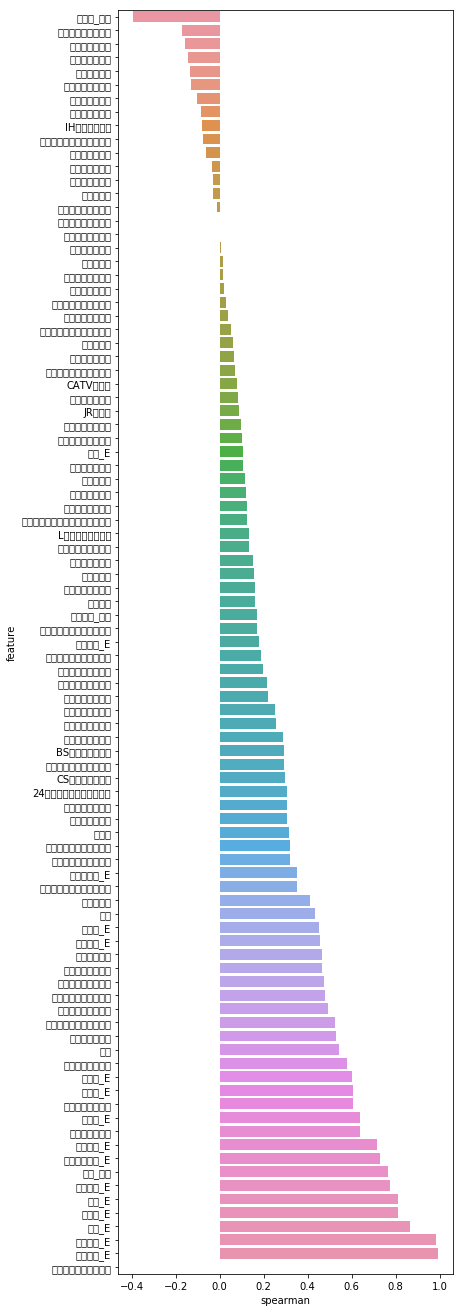

In [24]:
# カテゴリカルなデータを数値のデータに変換
## 変数ごとに、変数の値でsales priceをgroup byし、変数のユニーク値ごとのHousePriceの平均を計算する。
## そしてその平均が低いものから順に1番、2番と順位付けをしていく
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val

    ordering['spmean'] = frame[[feature, '賃料']].groupby(feature).mean()['賃料']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
#    display(ordering)
    ordering = ordering['ordering'].to_dict()

    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

qual_encoded = []
for q in qualitative:  
    encode(features, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

## スピアマンの順位相関係数を計算
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['賃料'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')

features_e = quantitative + qual_encoded
sns.set(font='Yu Gothic')
spearman(features, features_e)

C:\Users\tkst\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\tkst\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


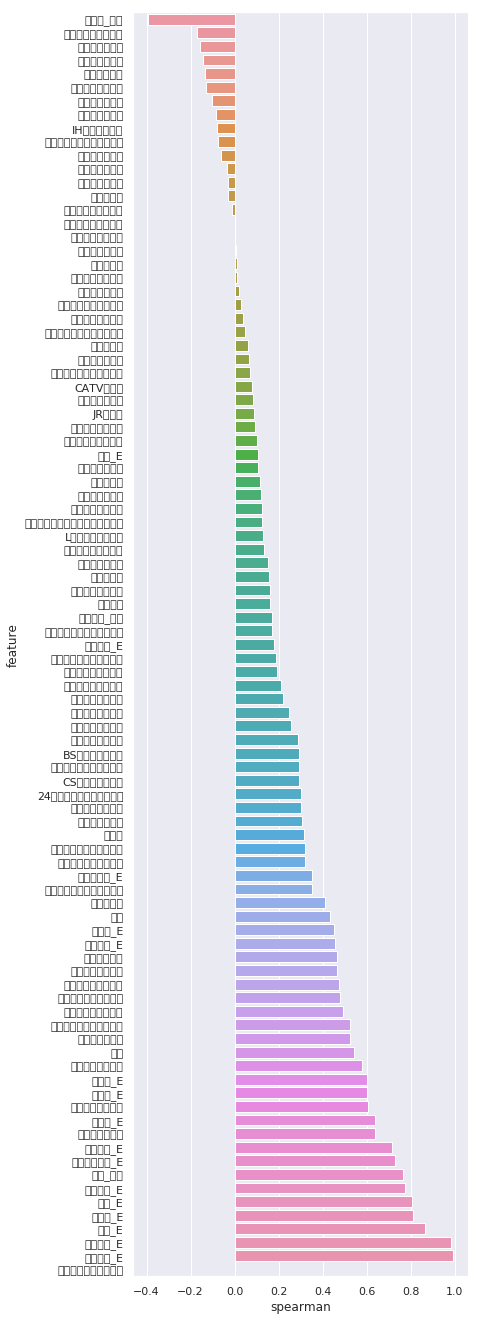

In [26]:
sns.set(font='IPAexGothic')
spearman(features, features_e)

In [ ]:
# 変数間相関を可視化

## 数値データの変数間相関を可視化
plt.figure(1)
corr = features[quantitative+['家賃']].corr()
sns.heatmap(corr)

## カテゴリカルデータの変数間相関を可視化
plt.figure(2)
corr = features[qual_encoded+['家賃']].corr()
sns.heatmap(corr)

## 数値データとカテゴリカルデータの変数間相関を可視化
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['家賃'], columns=qual_encoded+['家賃'])
for q1 in quantitative+['家賃']:
    for q2 in qual_encoded+['家賃']:
        corr.loc[q1, q2] = features[q1].corr(features[q2])
sns.heatmap(corr)

In [50]:
features_2 = features.drop(columns=['所在地', 'アクセス', '間取り', '築年数', '方角', '面積','所在階', 'バス・トイレ',
                                    'キッチン', '放送・通信', '室内設備', '駐車場', '周辺環境', '契約期間', '丁目'])

In [51]:
features_2.isnull().sum()

id                     0
建物構造                   0
JRダミー                  0
西武鉄道ダミー                0
東京地下鉄ダミー               0
京王電鉄ダミー                0
東急電鉄ダミー                0
東京都交通局ダミー              0
東武鉄道ダミー                0
京成電鉄ダミー                0
京浜急行電鉄ダミー              0
小田急電鉄ダミー               0
つくばエクスプレスダミー           0
ゆりかもめダミー               0
埼玉高速鉄道ダミー              0
東京モノレールダミー             0
東京臨海高速鉄道ダミー            0
北総鉄道ダミー                0
部屋数                    0
リビングダミー                0
ダイニングダミー               0
キッチンダミー                0
納戸ダミー                  0
新築ダミー                  0
築年数_修正                 0
面積_修正                  0
共同バスダミー                0
バスなしダミー                0
専用トイレダミー               0
バス・トイレ別ダミー             0
                   ...  
CATVダミー                0
CSアンテナダミー              0
BSアンテナダミー              0
インターネット使用料無料ダミー        0
有線放送ダミー                0
エアコン付ダミー               0
シューズボックスダミー            0
バルコニーダミー               0
フローリングダミー              0


In [52]:
features_2['契約期間_修正'].value_counts()

2.0     46940
5.0       514
3.0       469
1.0       309
4.0       124
7.0        13
6.0        13
10.0        7
15.0        2
22.0        2
12.0        1
Name: 契約期間_修正, dtype: int64

In [53]:
# 欠損を最頻値で埋める
features_2['契約期間_修正'].fillna(2, inplace=True)

In [54]:
features_2.head()

,id,建物構造,JRダミー,西武鉄道ダミー,東京地下鉄ダミー,京王電鉄ダミー,東急電鉄ダミー,東京都交通局ダミー,東武鉄道ダミー,京成電鉄ダミー,京浜急行電鉄ダミー,小田急電鉄ダミー,つくばエクスプレスダミー,ゆりかもめダミー,埼玉高速鉄道ダミー,東京モノレールダミー,東京臨海高速鉄道ダミー,北総鉄道ダミー,部屋数,リビングダミー,ダイニングダミー,キッチンダミー,納戸ダミー,新築ダミー,築年数_修正,面積_修正,共同バスダミー,バスなしダミー,専用トイレダミー,バス・トイレ別ダミー,シャワーダミー,追焚機能ダミー,浴室乾燥機ダミー,温水洗浄便座ダミー,洗面台独立ダミー,脱衣所ダミー,ガスコンロダミー,IHコンロダミー,電気コンロダミー,システムキッチンダミー,カウンターキッチンダミー,給湯ダミー,独立キッチンダミー,L字キッチンダミー,冷蔵庫ダミー,コンロ設置可能ダミー,インターネット対応ダミー,光ファイバーダミー,高速インターネットダミー,CATVダミー,CSアンテナダミー,BSアンテナダミー,インターネット使用料無料ダミー,有線放送ダミー,エアコン付ダミー,シューズボックスダミー,バルコニーダミー,フローリングダミー,24時間換気システムダミー,室内洗濯機置場ダミー,敷地内ごみ置き場ダミー,エレベーターダミー,タイル張りダミー,公営水道ダミー,下水ダミー,都市ガスダミー,プロパンガスダミー,駐車場空有ダミー,駐車場近隣ダミー,駐輪場空有ダミー,バイク置き場空有ダミー,定期借家ダミー,契約期間_修正,方角ダミー,階数,全体,階数地下ダミー,全体地下,単価正規化
0,1,RC（鉄筋コンクリート）,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,117,20.01,0,0,1,1,1,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,1,1,0,0,1,1,1,1,0,1,1,1,0,1,1,1,0,0,0,1,0,0,2.0,1,1.0,12.0,0,0.0,0.434577
1,2,鉄骨造,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,538,16.50,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,1,0,0,2.0,0,5.0,10.0,0,0.0,0.705244
2,3,RC（鉄筋コンクリート）,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,102,22.05,0,0,1,1,1,0,1,1,1,1,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,0,2.0,1,12.0,15.0,0,0.0,0.809914
3,4,RC（鉄筋コンクリート）,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,0,0,352,60.48,0,0,1,1,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,1,2.0,1,3.0,4.0,0,0.0,0.436606
4,5,木造,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,1,1,0,0,379,39.66,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,2.0,1,1.0,2.0,0,0.0,0.000000


In [55]:
features_2.dtypes

id                   int64
建物構造                object
JRダミー                int64
西武鉄道ダミー              int64
東京地下鉄ダミー             int64
京王電鉄ダミー              int64
東急電鉄ダミー              int64
東京都交通局ダミー            int64
東武鉄道ダミー              int64
京成電鉄ダミー              int64
京浜急行電鉄ダミー            int64
小田急電鉄ダミー             int64
つくばエクスプレスダミー         int64
ゆりかもめダミー             int64
埼玉高速鉄道ダミー            int64
東京モノレールダミー           int64
東京臨海高速鉄道ダミー          int64
北総鉄道ダミー              int64
部屋数                  int64
リビングダミー              int64
ダイニングダミー             int64
キッチンダミー              int64
納戸ダミー                int64
新築ダミー                int64
築年数_修正               int64
面積_修正              float64
共同バスダミー              int64
バスなしダミー              int64
専用トイレダミー             int64
バス・トイレ別ダミー           int64
                    ...   
CATVダミー              int64
CSアンテナダミー            int64
BSアンテナダミー            int64
インターネット使用料無料ダミー      int64
有線放送ダミー              int64
エアコン付ダミー             int64
シ

## **注意**get_dummiesする前にobjectをfloat,int型にしておく必要がある

In [56]:
final_features = pd.get_dummies(features_2).reset_index(drop=True)
print(final_features.shape)

(62732, 86)


In [57]:
final_features.head()

,id,JRダミー,西武鉄道ダミー,東京地下鉄ダミー,京王電鉄ダミー,東急電鉄ダミー,東京都交通局ダミー,東武鉄道ダミー,京成電鉄ダミー,京浜急行電鉄ダミー,小田急電鉄ダミー,つくばエクスプレスダミー,ゆりかもめダミー,埼玉高速鉄道ダミー,東京モノレールダミー,東京臨海高速鉄道ダミー,北総鉄道ダミー,部屋数,リビングダミー,ダイニングダミー,キッチンダミー,納戸ダミー,新築ダミー,築年数_修正,面積_修正,共同バスダミー,バスなしダミー,専用トイレダミー,バス・トイレ別ダミー,シャワーダミー,追焚機能ダミー,浴室乾燥機ダミー,温水洗浄便座ダミー,洗面台独立ダミー,脱衣所ダミー,ガスコンロダミー,IHコンロダミー,電気コンロダミー,システムキッチンダミー,カウンターキッチンダミー,給湯ダミー,独立キッチンダミー,L字キッチンダミー,冷蔵庫ダミー,コンロ設置可能ダミー,インターネット対応ダミー,光ファイバーダミー,高速インターネットダミー,CATVダミー,CSアンテナダミー,BSアンテナダミー,インターネット使用料無料ダミー,有線放送ダミー,エアコン付ダミー,シューズボックスダミー,バルコニーダミー,フローリングダミー,24時間換気システムダミー,室内洗濯機置場ダミー,敷地内ごみ置き場ダミー,エレベーターダミー,タイル張りダミー,公営水道ダミー,下水ダミー,都市ガスダミー,プロパンガスダミー,駐車場空有ダミー,駐車場近隣ダミー,駐輪場空有ダミー,バイク置き場空有ダミー,定期借家ダミー,契約期間_修正,方角ダミー,階数,全体,階数地下ダミー,全体地下,単価正規化,建物構造_ALC（軽量気泡コンクリート）,建物構造_PC（プレキャスト・コンクリート（鉄筋コンクリート））,建物構造_RC（鉄筋コンクリート）,建物構造_SRC（鉄骨鉄筋コンクリート）,建物構造_その他,建物構造_木造,建物構造_軽量鉄骨,建物構造_鉄骨造
0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,117,20.01,0,0,1,1,1,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,1,1,0,0,1,1,1,1,0,1,1,1,0,1,1,1,0,0,0,1,0,0,2.0,1,1.0,12.0,0,0.0,0.434577,0,0,1,0,0,0,0,0
1,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,538,16.50,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,1,0,0,2.0,0,5.0,10.0,0,0.0,0.705244,0,0,0,0,0,0,0,1
2,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,102,22.05,0,0,1,1,1,0,1,1,1,1,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,0,2.0,1,12.0,15.0,0,0.0,0.809914,0,0,1,0,0,0,0,0
3,4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,0,0,352,60.48,0,0,1,1,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,1,2.0,1,3.0,4.0,0,0.0,0.436606,0,0,1,0,0,0,0,0
4,5,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,1,1,0,0,379,39.66,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,2.0,1,1.0,2.0,0,0.0,0.000000,0,0,0,0,0,1,0,0


In [58]:
final_features.dtypes

id                                    int64
JRダミー                                 int64
西武鉄道ダミー                               int64
東京地下鉄ダミー                              int64
京王電鉄ダミー                               int64
東急電鉄ダミー                               int64
東京都交通局ダミー                             int64
東武鉄道ダミー                               int64
京成電鉄ダミー                               int64
京浜急行電鉄ダミー                             int64
小田急電鉄ダミー                              int64
つくばエクスプレスダミー                          int64
ゆりかもめダミー                              int64
埼玉高速鉄道ダミー                             int64
東京モノレールダミー                            int64
東京臨海高速鉄道ダミー                           int64
北総鉄道ダミー                               int64
部屋数                                   int64
リビングダミー                               int64
ダイニングダミー                              int64
キッチンダミー                               int64
納戸ダミー                                 int64
新築ダミー                           

In [59]:
# 各特徴量のユニークな値の個数を見る
@widgets.interact(column=final_features.columns)
def fetures_value_counts(column):
  return features[column].value_counts()

interactive(children=(Dropdown(description='column', options=('id', 'JRダミー', '西武鉄道ダミー', '東京地下鉄ダミー', '京王電鉄ダミー',…

In [60]:
final_features[final_features.index==20231]

,id,JRダミー,西武鉄道ダミー,東京地下鉄ダミー,京王電鉄ダミー,東急電鉄ダミー,東京都交通局ダミー,東武鉄道ダミー,京成電鉄ダミー,京浜急行電鉄ダミー,小田急電鉄ダミー,つくばエクスプレスダミー,ゆりかもめダミー,埼玉高速鉄道ダミー,東京モノレールダミー,東京臨海高速鉄道ダミー,北総鉄道ダミー,部屋数,リビングダミー,ダイニングダミー,キッチンダミー,納戸ダミー,新築ダミー,築年数_修正,面積_修正,共同バスダミー,バスなしダミー,専用トイレダミー,バス・トイレ別ダミー,シャワーダミー,追焚機能ダミー,浴室乾燥機ダミー,温水洗浄便座ダミー,洗面台独立ダミー,脱衣所ダミー,ガスコンロダミー,IHコンロダミー,電気コンロダミー,システムキッチンダミー,カウンターキッチンダミー,給湯ダミー,独立キッチンダミー,L字キッチンダミー,冷蔵庫ダミー,コンロ設置可能ダミー,インターネット対応ダミー,光ファイバーダミー,高速インターネットダミー,CATVダミー,CSアンテナダミー,BSアンテナダミー,インターネット使用料無料ダミー,有線放送ダミー,エアコン付ダミー,シューズボックスダミー,バルコニーダミー,フローリングダミー,24時間換気システムダミー,室内洗濯機置場ダミー,敷地内ごみ置き場ダミー,エレベーターダミー,タイル張りダミー,公営水道ダミー,下水ダミー,都市ガスダミー,プロパンガスダミー,駐車場空有ダミー,駐車場近隣ダミー,駐輪場空有ダミー,バイク置き場空有ダミー,定期借家ダミー,契約期間_修正,方角ダミー,階数,全体,階数地下ダミー,全体地下,単価正規化,建物構造_ALC（軽量気泡コンクリート）,建物構造_PC（プレキャスト・コンクリート（鉄筋コンクリート））,建物構造_RC（鉄筋コンクリート）,建物構造_SRC（鉄骨鉄筋コンクリート）,建物構造_その他,建物構造_木造,建物構造_軽量鉄骨,建物構造_鉄骨造
20231,20232,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,1,1,1,0,6245,51.3,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2.0,1,3.0,3.0,0,0.0,0.291905,0,0,0,0,0,0,0,1


In [61]:
# 前処理を終えた特徴量
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(X):, :]

# 異常値のあるデータを削除
outliers = [20231, 20427, 20926]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

# 過学習を防ぐための措置？
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)

X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

X (31467, 86) y (31467,) X_sub (31262, 86)
X (31467, 83) y (31467,) X_sub (31262, 83)


## モデル作成

交差検証用の準備

In [64]:
print('START ML', datetime.now(), )

# データを10個に分けて交差検証
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# 交差検証のスコアを測る関数
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)

START ML 2019-10-09 13:05:09.298780


モデル作成

In [63]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM/
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile

^C
[WinError 3] 指定されたパスが見つかりません。: '/content/LightGBM/'
C:\Users\tkst\Documents\compe\mynavi


'cmake' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。
'make' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。
'sudo' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


[WinError 3] 指定されたパスが見つかりません。: '/content/LightGBM/python-package'
C:\Users\tkst\Documents\compe\mynavi


'sudo' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。
'sudo' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


In [65]:
# いろんなモデルをつくる  
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas2,
                               random_state=42, cv=kfolds))
                              
elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas,
                                        cv=kfolds, l1_ratio=e_l1ratio))

svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )





xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='gpu:reg:linear', nthread=-1,predictor='gpu_predictor',tree_method='gpu_exact',
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
                                   
# stack
stack_gen = StackingCVRegressor(regressors=(ridge, elasticnet,
                                            gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)



交差検証スコアの計算

In [ ]:
print('TEST score on CV')

score = cv_rmse(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("Lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

TEST score on CV
Kernel Ridge score: 32930.9617 (6095.9575)
 2019-10-09 13:06:27.299658


In [ ]:
# 予測する
print('START Fit')
print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
print(datetime.now(), 'elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(X, y)

print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(X, y)

print(datetime.now(), 'svr')
svr_model_full_data = svr.fit(X, y)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print(datetime.now(), 'lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

print(datetime.now(), 'xgboost')
xgb_model_full_data = xgboost.fit(X, y)

In [ ]:
# 作成したいろんなモデルをブレンディング
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.1 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.20 * xgb_model_full_data.predict(X)) + \
            (0.15 * lgb_model_full_data.predict(X)) + \
            (0.25 * stack_gen_model.predict(np.array(X))))

print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

予測する

In [ ]:
print('RMSLE score on train data:')
print(rmsle(y, (blend_models_predict(X))))

In [ ]:
# 提出用データフレームを作成
print('Predict submission', datetime.now(),)
submission = pd.read_csv("./sample_submit.csv", header=None)
submission.iloc[:,1] = blend_models_predict(X_sub)

# 範囲の外側の値を丸める
q1 = submission[1].quantile(0.0045)
q2 = submission[1].quantile(0.99)

submission[1] = submission[1].apply(lambda x: x if x > q1 else x*0.77)
submission[1] = submission[1].apply(lambda x: x if x < q2 else x*1.1)

#csvに出力
submission.to_csv("new_submission.csv", index=False)
print('Save submission', datetime.now(),)